# SAM GENERATOR

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [10]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

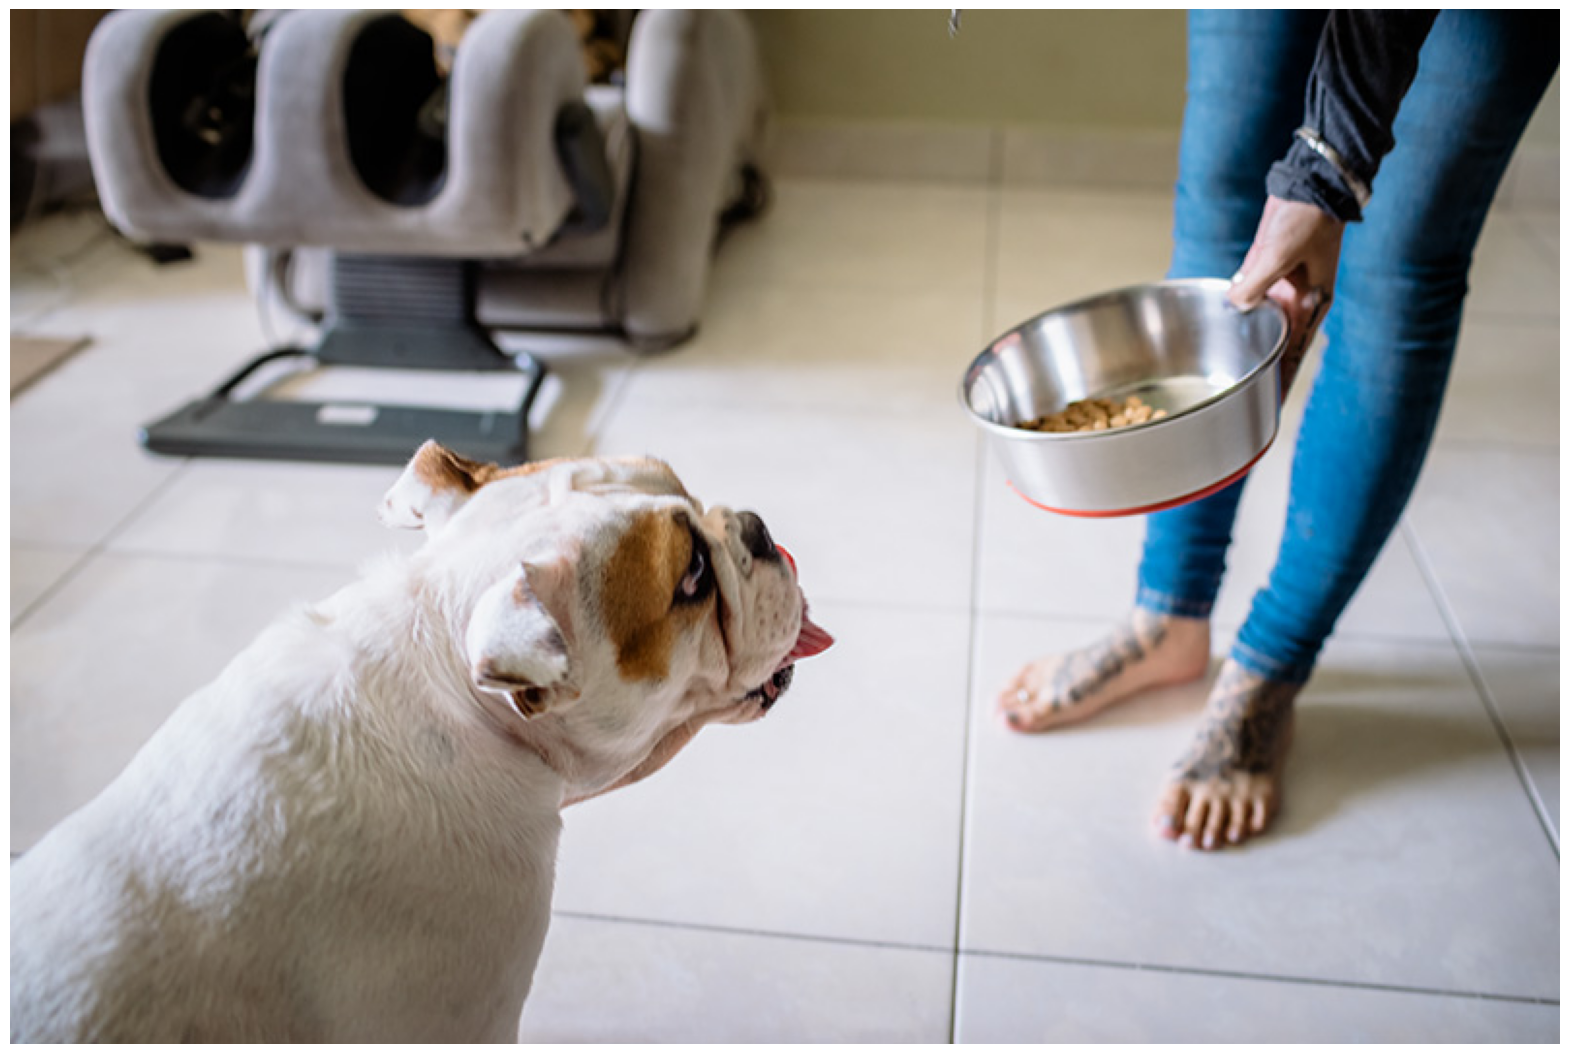

In [11]:
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [12]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/mnt/B-SSD/maltamed/SAM-zero-shot/segment-anything-main/checkpoints/sam_vit_h.pth"

device = "cuda:0"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


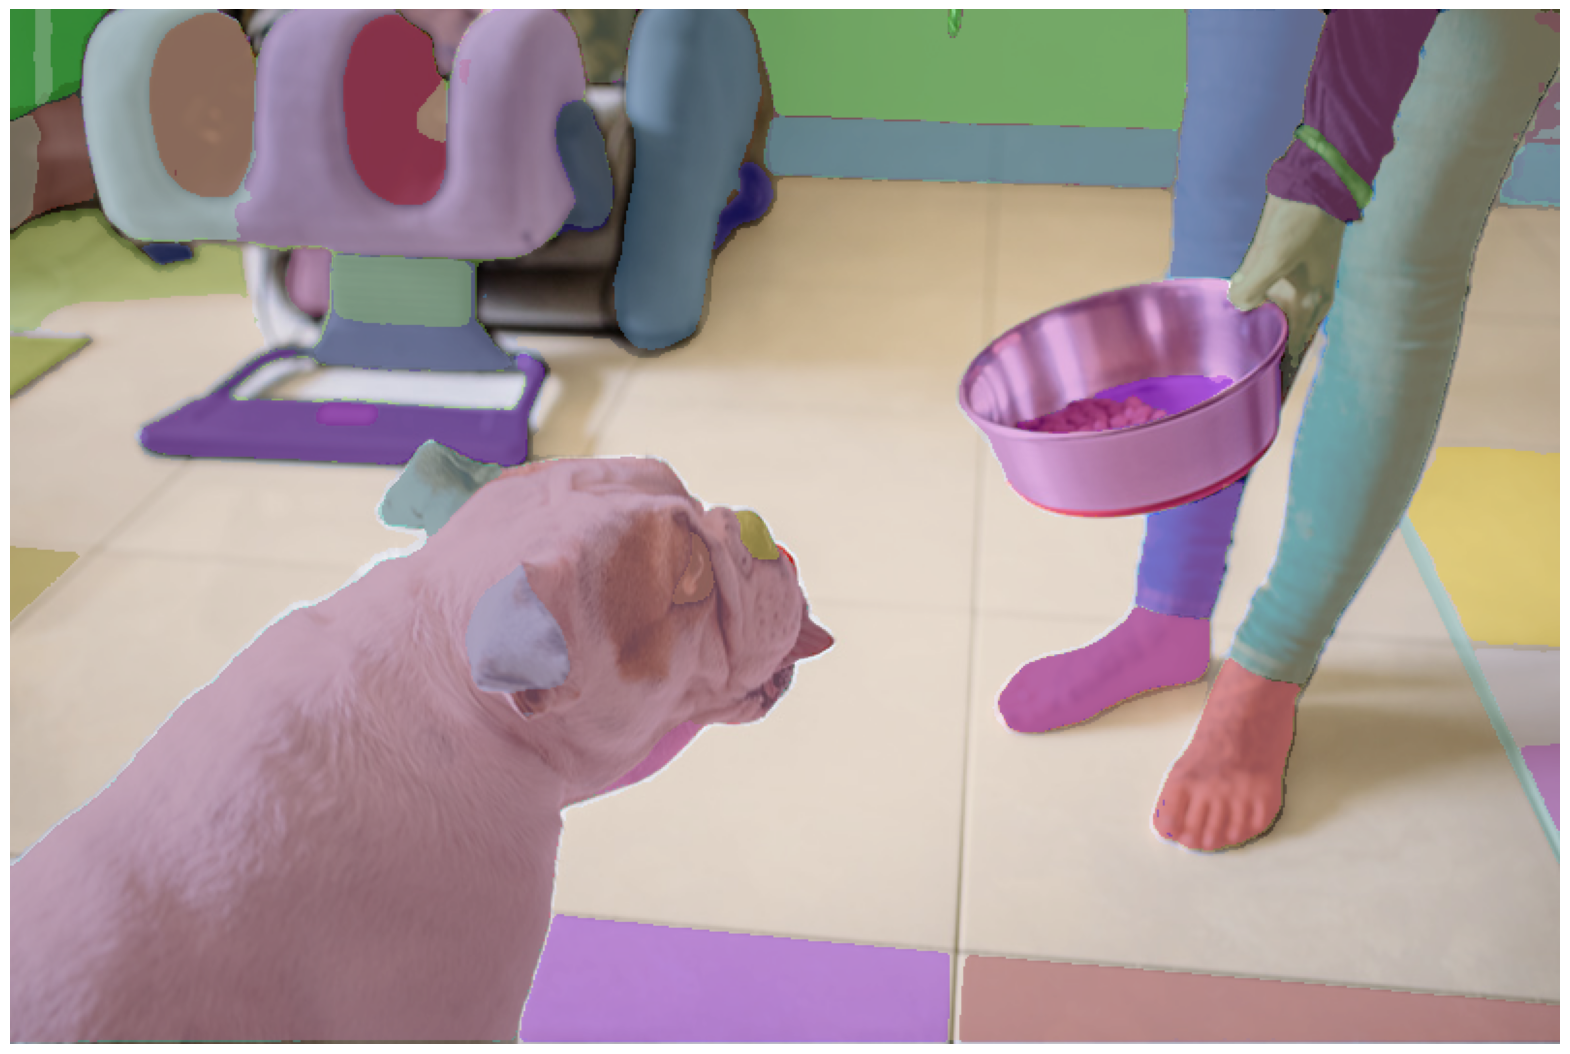

In [13]:
masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

# SAM PREDICTOR

In [32]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2 

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

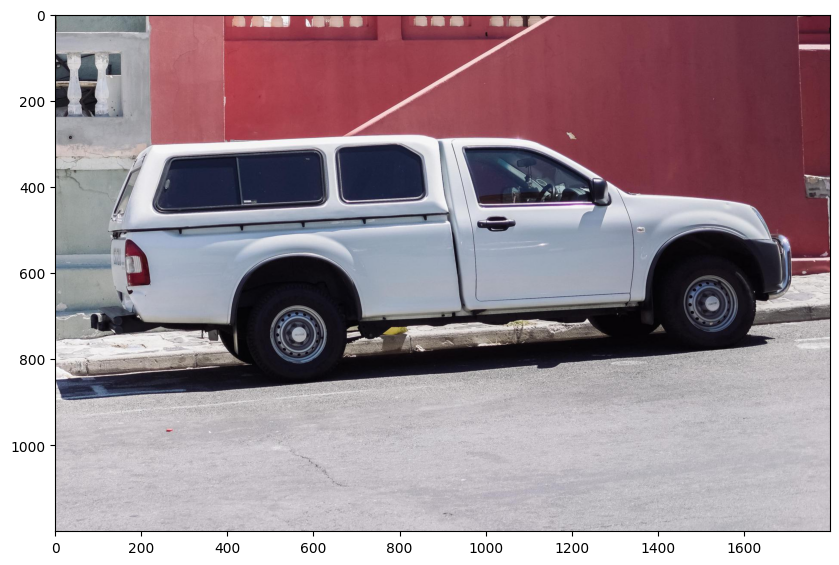

In [33]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [34]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/mnt/B-SSD/maltamed/SAM-zero-shot/segment-anything-main/checkpoints/sam_vit_h.pth"
device = "cuda"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

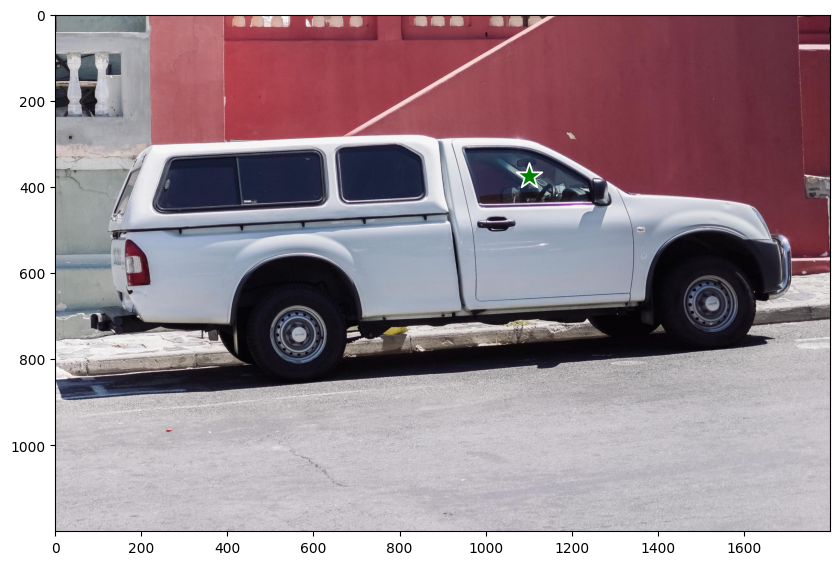

In [38]:
predictor.set_image(image)

input_point = np.array([[1100, 375]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [43]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

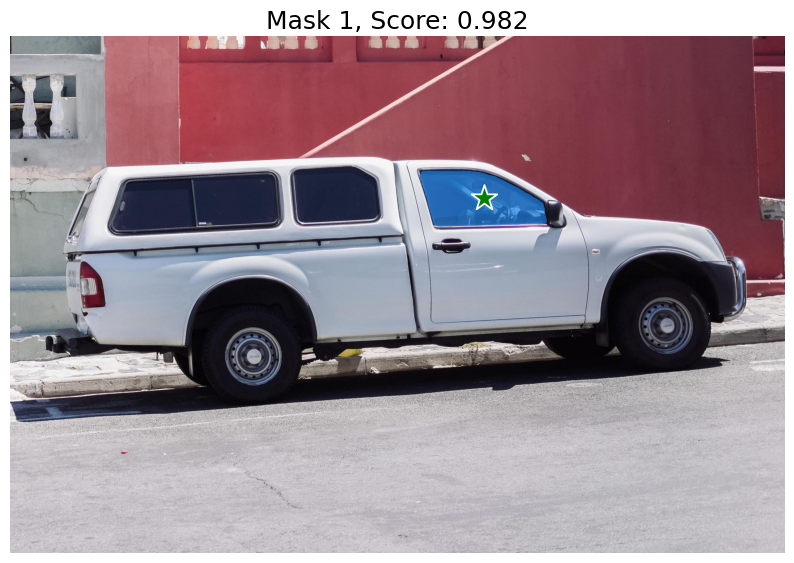

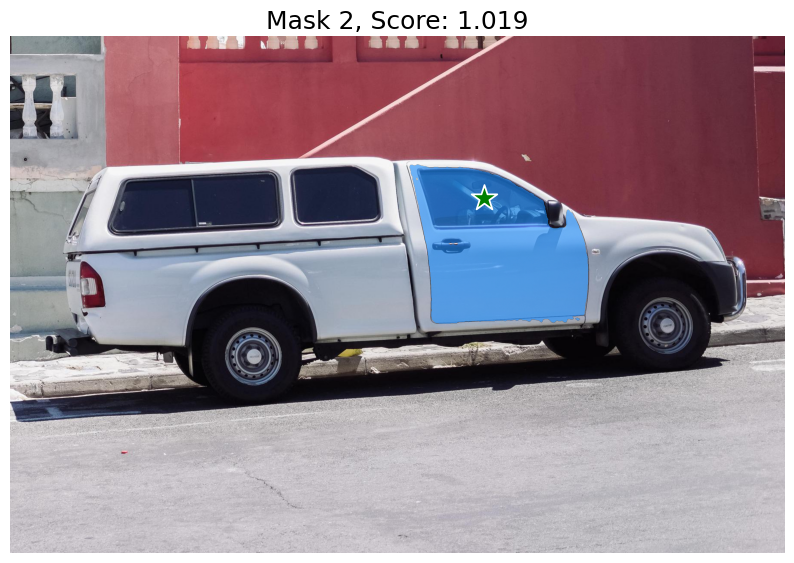

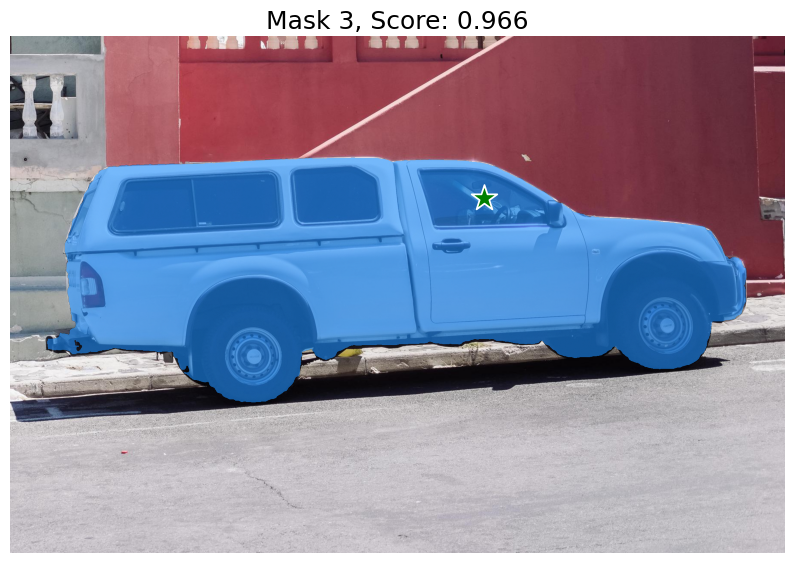

In [44]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

# Teste com imagens médicas

In [75]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from monai.transforms import LoadImaged, ScaleIntensityRanged, Compose
from monai.data import DataLoader, Dataset, decollate_batch
from monai.utils import first

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

def random_coordinate(mask):
    # Obtém as coordenadas de todos os pixels com o valor desejado
    coordenadas = np.column_stack(np.where(mask == 1))

    # Seleciona uma coordenada aleatória
    coordenada_aleatoria = coordenadas[np.random.choice(len(coordenadas))]
    return coordenada_aleatoria

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

data_dir = '/mnt/B-SSD/maltamed/datasets/LITSkaggle/'
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files = data_dicts[:1]

train_transforms = Compose(
    LoadImaged(keys=["image", "label"]),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-57,
        a_max=164,
        b_min=0,
        b_max=255,
        clip=True,
    ),
)

check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, mask = check_data["image"][0], check_data["label"][0]

In [76]:
mask = mask.numpy()
coordinate = random_coordinate(mask)
print("Mask shape:", mask.shape)
print("Random coordinate:", coordinate)

sam_checkpoint = "/mnt/B-SSD/maltamed/SAM-zero-shot/segment-anything-main/checkpoints/sam_vit_h.pth"
device = "cuda"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Mask shape: (512, 512, 75)
Random coordinate: [180 276  66]


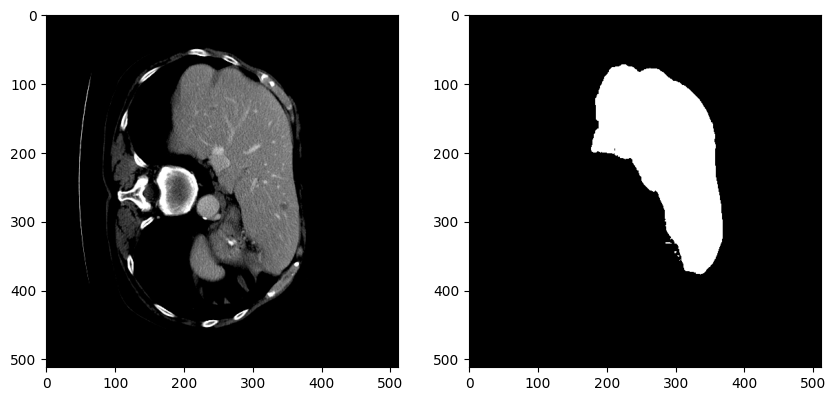

In [77]:
# test
mask = np.where(mask > 0, 1, 0)
image = np.array(image)
#image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
image = np.clip(image, 0, 255)

img = np.array(image[:,:,coordinate[2]]).astype(np.uint8)
msk = np.array(mask[:,:,coordinate[2]]).astype(np.uint8)

msk = cv2.cvtColor(msk, cv2.COLOR_GRAY2RGB)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# plot img and msk side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img, cmap="gray")
ax[1].imshow(msk*255, cmap="gray")

#print(mask.shape)

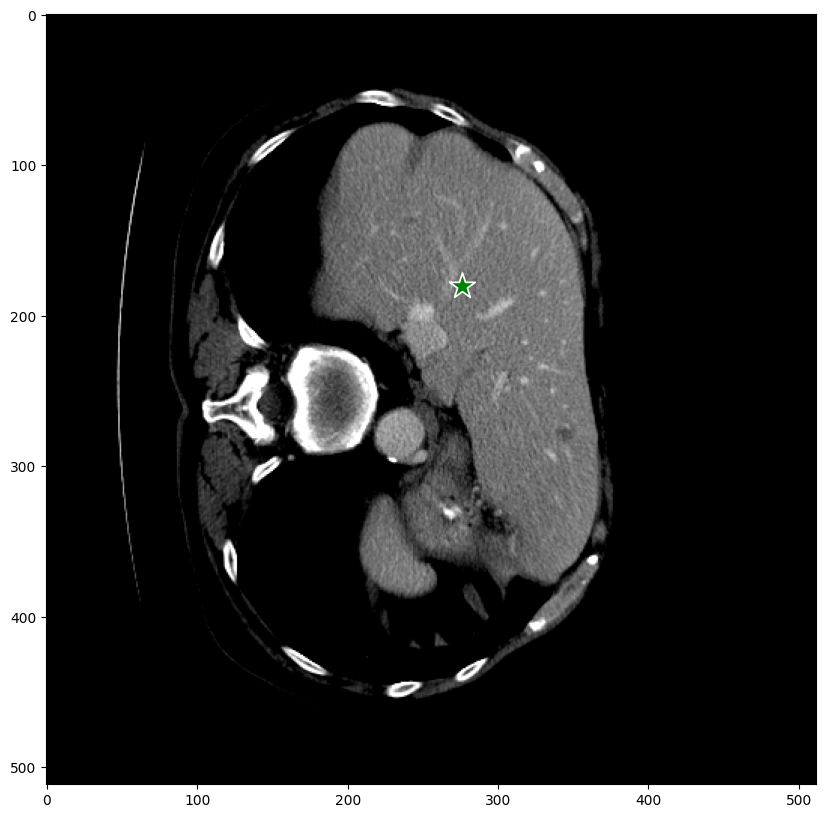

In [78]:
predictor.set_image(img)

#input_point = np.array([coordinate[:2]])
input_point = np.array([[coordinate[1], coordinate[0]]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

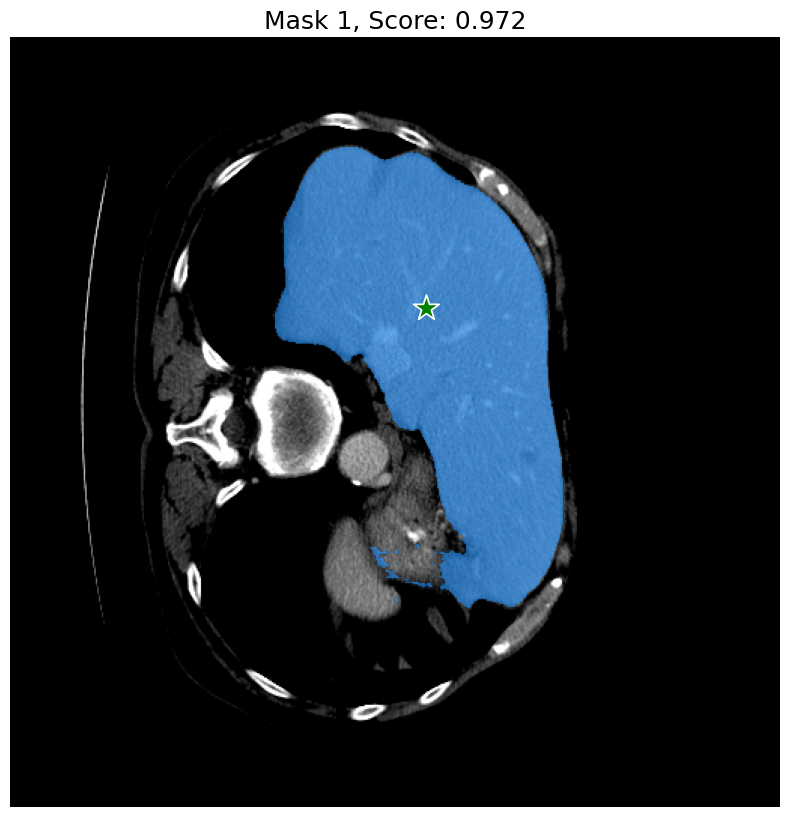

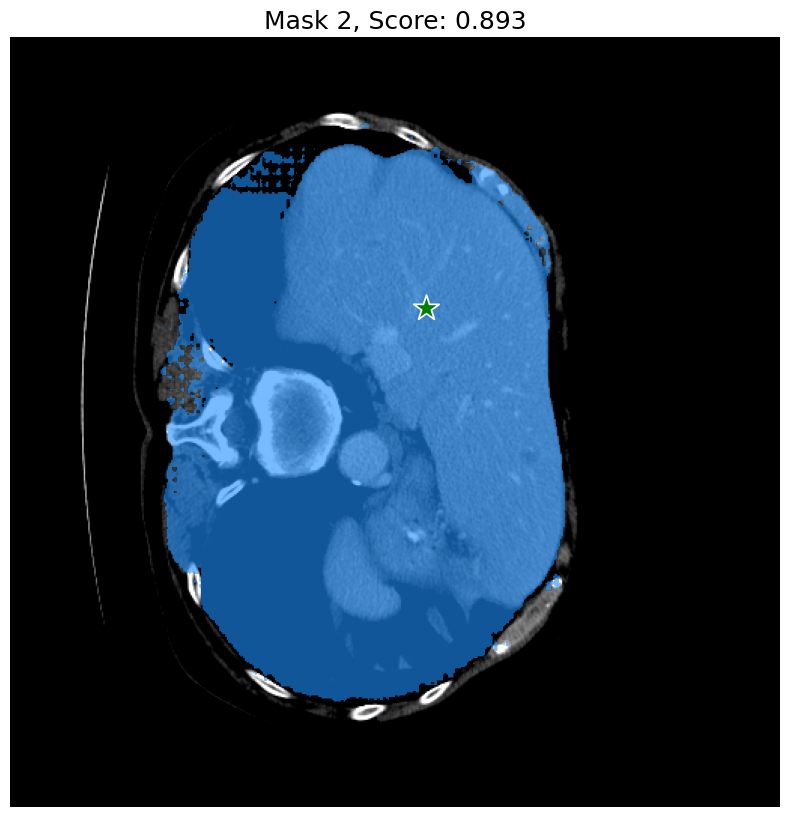

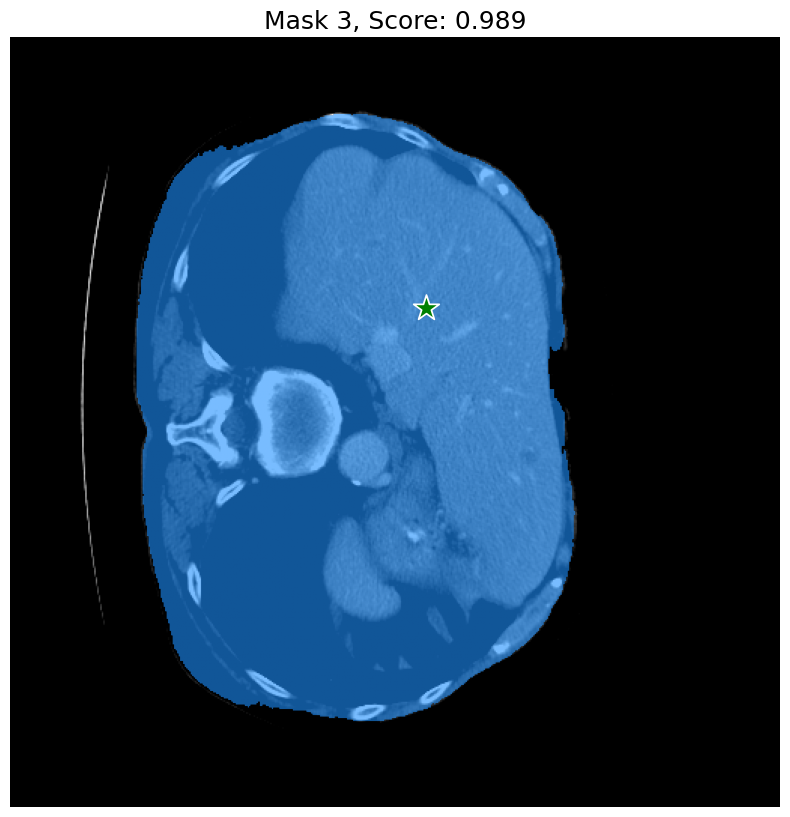

In [79]:
masks_pred, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (m, score) in enumerate(zip(masks_pred, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_mask(m, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

Text(0.5, 1.0, 'Ground Truth Mask')

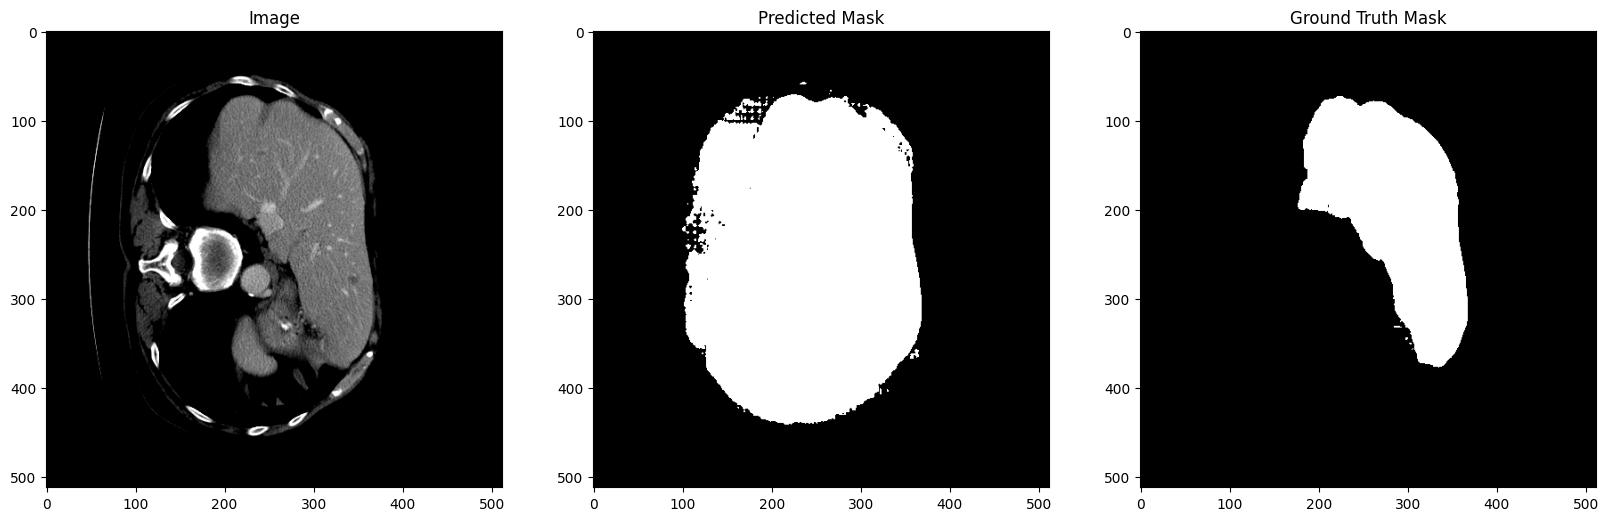

In [80]:
masks_pred_0_1 = masks_pred[0,:,:] + masks_pred[1,:,:]
# plot img and msk side by side
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img, cmap="gray")
ax[1].imshow(masks_pred_0_1*255, cmap="gray")
ax[2].imshow(msk*255, cmap="gray")

# add title to ax
ax[0].set_title('Image')
ax[1].set_title('Predicted Mask')
ax[2].set_title('Ground Truth Mask')

In [53]:
from monai.metrics import DiceMetric
import torch

dice_metric = DiceMetric(include_background=True, reduction="mean")

dice_metric(y_pred=torch.Tensor(masks_pred_0_1*1).unsqueeze(0), y=torch.Tensor(msk[:,:,0]*1).unsqueeze(0))
metric = dice_metric.aggregate().item()
print("Dice metric:", metric)

Dice metric: 0.8950618505477905


In [54]:
# test

print(mask.shape)

non_zero_slices = np.any(mask, axis=(0, 1))

(512, 512, 75)


In [55]:
print(non_zero_slices)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False]


In [56]:
mask_tmp = mask[:,:,non_zero_slices]

In [57]:
mask_tmp = mask[:,:,non_zero_slices]
print(mask_tmp.shape)

(512, 512, 29)


In [58]:
from monai.data import NibabelWriter

writer_ct = NibabelWriter()
# chenge firts to last
mask_tmp = np.moveaxis(mask_tmp, 2, 0)
writer_ct.set_data_array(mask_tmp)
writer_ct.write("/mnt/B-SSD/maltamed/SAM-zero-shot/code/image.nii")

In [59]:
print(np.moveaxis(mask_tmp, 2, 0).shape)

(512, 29, 512)


In [60]:
print(mask_tmp.shape)

(29, 512, 512)


In [61]:
import glob
import os
import cv2
import torch
import tqdm

import numpy as np

from segment_anything import sam_model_registry, SamPredictor
from monai.transforms import LoadImaged, ScaleIntensityRanged, Compose
from monai.data import DataLoader, Dataset, decollate_batch
from monai.utils import first
from monai.metrics import DiceMetric
from utils import utils

data_dir = '/mnt/B-SSD/maltamed/datasets/LITSkaggle/'
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files = data_dicts[1:2]

train_transforms = Compose(
    LoadImaged(keys=["image", "label"]),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-57,
        a_max=164,
        b_min=0,
        b_max=255,
        clip=True,
    ),
)

check_ds = Dataset(data=train_files, transform=train_transforms)
loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, mask = check_data["image"][0], check_data["label"][0]

mask = mask.numpy()

sam_checkpoint = "/mnt/B-SSD/maltamed/SAM-zero-shot/segment-anything-main/checkpoints/sam_vit_h.pth"
device = "cuda"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

dice_metric_0 = DiceMetric(include_background=True, reduction="mean")
dice_metric_1 = DiceMetric(include_background=True, reduction="mean")
dice_metric_2 = DiceMetric(include_background=True, reduction="mean")
for j in tqdm.tqdm(loader):
    image, mask = j["image"][0], j["label"][0]
    mask = mask.numpy()
    non_zero_slices = np.any(mask, axis=(0, 1))
    mask = mask[:,:,non_zero_slices]
    image = image[:,:,non_zero_slices]

    mask = np.where(mask > 0, 1, 0)
    image = np.array(image)
    image = np.clip(image, 0, 255)

    for i in range(image.shape[-1]):
        mask_ = mask[:,:,i]
        image_ = image[:,:,i]
        coordinate = utils.random_coordinate(mask)
        image_ = np.array(image_).astype(np.uint8)
        mask_ = np.array(mask_).astype(np.uint8)

        mask_ = cv2.cvtColor(mask_, cv2.COLOR_GRAY2RGB)
        image_ = cv2.cvtColor(image_, cv2.COLOR_GRAY2RGB)
        
        predictor.set_image(image_)

        input_point = np.array([[coordinate[1], coordinate[0]]])
        input_label = np.array([1])
        masks_pred, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
        )

        masks_pred_0_1 = masks_pred[0,:,:] #+ masks_pred[1,:,:] #+ masks_pred[2,:,:]
        dice_metric_0(y_pred=torch.Tensor(masks_pred[0,:,:]*1).unsqueeze(0), y=torch.Tensor(mask_[:,:,0]*1).unsqueeze(0))
        dice_metric_1(y_pred=torch.Tensor((masks_pred[0,:,:]+masks_pred[1,:,:])*1).unsqueeze(0), y=torch.Tensor(mask_[:,:,0]*1).unsqueeze(0))
        dice_metric_2(y_pred=torch.Tensor((masks_pred[0,:,:]+masks_pred[1,:,:]+masks_pred[2,:,:])*1).unsqueeze(0), y=torch.Tensor(mask_[:,:,0]*1).unsqueeze(0))
dice_0 = dice_metric_0.aggregate().item()
dice_1 = dice_metric_1.aggregate().item()
dice_2 = dice_metric_2.aggregate().item()

dice_metric_0.reset()
dice_metric_1.reset()
dice_metric_2.reset()

100%|██████████| 1/1 [00:15<00:00, 15.96s/it]


In [62]:
print("Dice metric 0:", dice_0)
print("Dice metric 1:", dice_1)
print("Dice metric 2:", dice_2)

Dice metric 0: 0.5693556666374207
Dice metric 1: 0.55574631690979
Dice metric 2: 0.48519688844680786


In [63]:
print("Dice metric:", metric)

Dice metric: 0.8950618505477905


In [64]:
print("Dice metric:", metric)

Dice metric: 0.8950618505477905


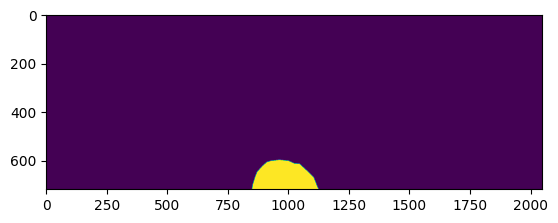

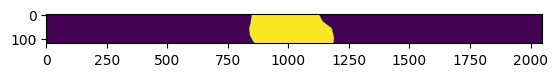

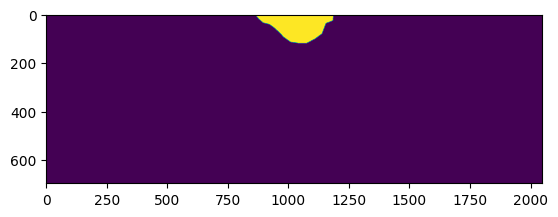

In [24]:
import numpy as np
import cv2

# Read in the binary mask image
mask = cv2.imread('/mnt/B-SSD/maltamed/datasets/2D/ISIC/mask/ISIC_0000102_segmentation.png', cv2.IMREAD_GRAYSCALE)

# Find the indices of the rows where there are non-zero values
non_zero_rows = np.where(np.any(mask, axis=1))[0]

# split in three parts
total = non_zero_rows[-1] - non_zero_rows[0]
split = total // 3

primeiro = non_zero_rows[0] + split
segundo = non_zero_rows[0] + split*2
terceiro = non_zero_rows[0] + split*3

# Split the mask based on the non-zero rows
part1 = mask[:primeiro, :]
part2 = mask[primeiro+1:segundo, :]
part3 = mask[segundo+1:, :]

import matplotlib.pyplot as plt
# plot using plt
plt.imshow(part1)
plt.show()
plt.imshow(part2)
plt.show()
plt.imshow(part3)
plt.show()

In [28]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def random_coordinate(mask):
    # Obtém as coordenadas de todos os pixels com o valor desejado
    coordenadas = np.column_stack(np.where(mask == 1))

    # Seleciona uma coordenada aleatória
    coordenada_aleatoria = coordenadas[np.random.choice(len(coordenadas))]
    return coordenada_aleatoria
    

In [ ]:
mask = mask.numpy()
coordinate_1 = random_coordinate(mask)
coordinate_2 = random_coordinate(mask)
coordinate_3 = random_coordinate(mask)

#input_point = np.array([coordinate[:2]])
input_point = np.array([[coordinate[1], coordinate[0]]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()


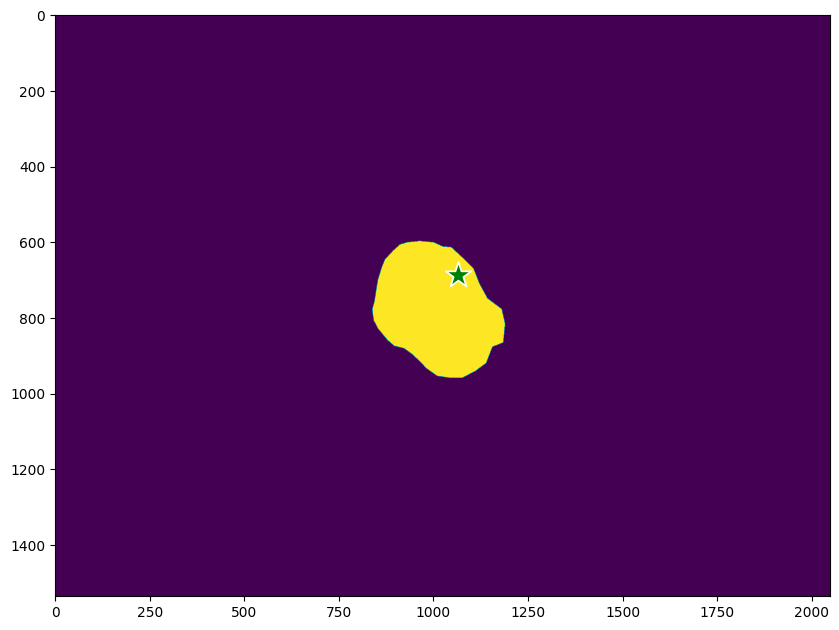

In [47]:
import numpy as np
import cv2

# Read in the binary mask image
mask = cv2.imread('/mnt/B-SSD/maltamed/datasets/2D/ISIC/mask/ISIC_0000102_segmentation.png', cv2.IMREAD_GRAYSCALE)

# Find the indices of the rows where there are non-zero values
non_zero_rows = np.where(np.any(mask, axis=1))[0]

# split in three parts
total = non_zero_rows[-1] - non_zero_rows[0]
split = total // 3

primeiro = non_zero_rows[0] + split
segundo = non_zero_rows[0] + split*2
terceiro = non_zero_rows[0] + split*3

# Split the mask based on the non-zero rows
part1 = mask[:primeiro, :]
part2 = mask[primeiro+1:segundo, :]
part3 = mask[segundo+1:, :]


# Define a parte da imagem que deseja considerar
parte_desejada = mask[:primeiro, :] # por exemplo, uma região retangular da imagem

# Obtém as coordenadas de todos os pixels com o valor desejado dentro da parte desejada
coordenadas_parte = np.column_stack(np.where(parte_desejada > 0))

# Seleciona uma coordenada aleatória da parte desejada
coordenada_aleatoria_parte = coordenadas_parte[np.random.choice(len(coordenadas_parte))]

# Converte a coordenada para as coordenadas da imagem completa
coordenada_aleatoria_1 = (coordenada_aleatoria_parte[0], coordenada_aleatoria_parte[1])

# Define a parte da imagem que deseja considerar
parte_desejada = mask[primeiro+1:segundo, :] # por exemplo, uma região retangular da imagem

# Obtém as coordenadas de todos os pixels com o valor desejado dentro da parte desejada
coordenadas_parte = np.column_stack(np.where(parte_desejada > 0))

# Seleciona uma coordenada aleatória da parte desejada
coordenada_aleatoria_parte = coordenadas_parte[np.random.choice(len(coordenadas_parte))]

# Converte a coordenada para as coordenadas da imagem completa
coordenada_aleatoria_2 = (coordenada_aleatoria_parte[0] + primeiro+1, coordenada_aleatoria_parte[1])

# Define a parte da imagem que deseja considerar
parte_desejada = mask[segundo+1:, :] # por exemplo, uma região retangular da imagem

# Obtém as coordenadas de todos os pixels com o valor desejado dentro da parte desejada
coordenadas_parte = np.column_stack(np.where(parte_desejada > 0))

# Seleciona uma coordenada aleatória da parte desejada
coordenada_aleatoria_parte = coordenadas_parte[np.random.choice(len(coordenadas_parte))]

# Converte a coordenada para as coordenadas da imagem completa
coordenada_aleatoria_3 = (coordenada_aleatoria_parte[0] + segundo+1, coordenada_aleatoria_parte[1])

input_point = np.array([[coordenada_aleatoria_1[1], coordenada_aleatoria_1[0]], [coordenada_aleatoria_2[1], coordenada_aleatoria_2[0]], [coordenada_aleatoria_3[1], coordenada_aleatoria_3[0]]])
input_label = np.array([1, 1, 1])

plt.figure(figsize=(10,10))
plt.imshow(mask)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

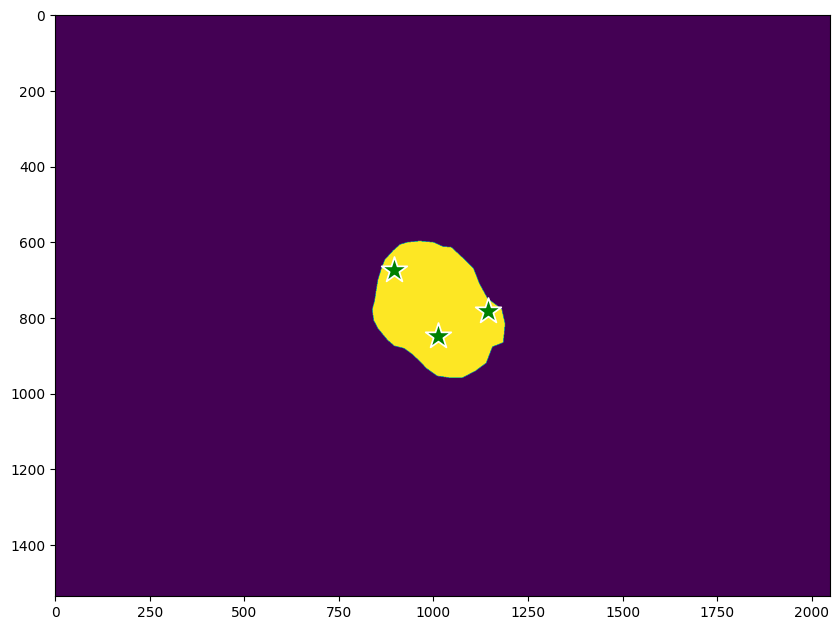

In [51]:
import numpy as np
import cv2

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def random_splits(mask, n_splits=3):
    mask = cv2.erode(mask, np.ones((30,30), np.uint8), iterations=1)
    # Find the indices of the rows where there are non-zero values
    non_zero_rows = np.where(np.any(mask, axis=1))[0]

    # split in three parts
    total = non_zero_rows[-1] - non_zero_rows[0]
    split_size = total // n_splits

    coords = []

    for n in range(n_splits):
        if n == 0:
            start = 0
            end = (non_zero_rows[0] + split_size * (n+1))

        elif n == n_splits-1:
            start = (non_zero_rows[0] + split_size * (n))+1 if n ==1 else (end+1)
            end = mask.shape[0]

        else:
            # Define a parte da imagem que deseja considerar
            start = (non_zero_rows[0] + split_size * (n))+1 if n ==1 else (end+1)
            end = (non_zero_rows[0] + split_size * (n+1))


        parte_desejada = mask[start:end, :] # por exemplo, uma região retangular da imagem

        # Obtém as coordenadas de todos os pixels com o valor desejado dentro da parte desejada
        coordenadas_parte = np.column_stack(np.where(parte_desejada > 0))

        # Seleciona uma coordenada aleatória da parte desejada
        coordenada_aleatoria_parte = coordenadas_parte[np.random.choice(len(coordenadas_parte))]

        # Converte a coordenada para as coordenadas da imagem completa
        coords.append([coordenada_aleatoria_parte[1], coordenada_aleatoria_parte[0]+start])

    input_point = np.array(coords)
    input_label = np.array([1]*n_splits)
    return input_point, input_label

mask = cv2.imread('/mnt/B-SSD/maltamed/datasets/2D/ISIC/mask/ISIC_0000102_segmentation.png', cv2.IMREAD_GRAYSCALE)
input_point, input_label = random_splits(mask, n_splits=3)

plt.figure(figsize=(10,10))
plt.imshow(mask)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [ ]:
primeiro = non_zero_rows[0] + split
segundo = non_zero_rows[0] + split*2
terceiro = non_zero_rows[0] + split*3

# Define a parte da imagem que deseja considerar
parte_desejada = mask[primeiro+1:segundo, :] # por exemplo, uma região retangular da imagem

In [9]:
split_size * n_splits

360

In [6]:
split

839

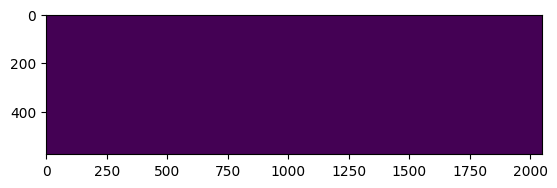

In [5]:
import matplotlib.pyplot as plt

plt.imshow(mask[start:end, :])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import find_objects

# Load binary mask
binary_mask = cv2.imread('/mnt/B-SSD/maltamed/datasets/2D/ISIC/mask/ISIC_0000102_segmentation.png', cv2.IMREAD_GRAYSCALE).numpy()
# Find the objects in the binary mask
objects = find_objects(binary_mask)

# Get the coordinates of the first object
ymin, xmin, ymax, xmax = objects[0]

# Create the bounding box
bbox = [xmin, ymin, xmax, ymax]

# Plot the binary mask with bounding box
fig, ax = plt.subplots()
ax.imshow(binary_mask, cmap='gray')
rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()